Dervla Gargan - 22346279
Mark Langtry - 22340475
Amy McMahon - 22346619

Code executed without errors :)

https://github.com/shivaverma/OpenAIGym/blob/master/mountain-car/MountainCar-v0.py

Importing librarys and creating the gym environment

In [7]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
env = gym.make('MountainCar-v0')



Creating the deep q learning network

In [8]:
class DQN:


    def __init__(self, action_space, state_space):
        
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0 #
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01 #
        self.lr = 0.001
        self.epsilon_decay = .995 #
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):
        #creating the model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_space, activation=relu))
        model.add(Dense(24, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        #adding the state, action, reward, next state and done to the memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state): 
        # epsilon greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    #method to replay the memory
    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        #reshaping the states and next states
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        #creating the target, using the bellman equation
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        #creating the targets
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        #fitting the model with the states and the targets
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



returning the reward based on the state

In [9]:
def get_reward(state):
    #return the reward based on the state
    if state[0] >= 0.5:
        print("Car has reached the goal")
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0


training the network

In [10]:

def train_dqn(episode):
    #training the model
    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        #resetting the environment
        state = env.reset()
        #getting the state
        state = np.array(state[0])
        #reshaping the state
        state = np.reshape(state, (1, agent.state_space))
        score = 0
        max_steps = 500

        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            #taking action and observing the reward
            next_state, reward, done, _, _ = env.step(action)
            reward = get_reward(next_state)
            score += reward
            #next state after taking action
            next_state = np.reshape(next_state, (1, agent.state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss



running the network and making a graph

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


/opt/homebrew/lib/python3.11/site-packages/gym/envs/classic_control/mountain_car.py:171: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(
/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 [==============================] - 0s 10ms/step
Car has reached the goal
episode: 14/60, score: 213.77564688342596
1/1 [==============================] - 0s 10ms/step
Car has reached the goal
episode: 15/60, score: 169.2883463700324
1/1 [==============================] - 0s 8ms/step
Car has reached the goal
episode: 19/60, score: 186.7527972445964
1/1 [==============================] - 0s 9ms/step
Car has reached the goal
episode: 20/60, score: 176.99664337785123
1/1 [==============================] - 0s 9ms/step
Car has reached the goal
episode: 21/60, score: 165.19364032540628
1/1 [==============================] - 0s 10ms/step
Car has reached the goal
episode: 22/60, score: 191.56515804478872
1/1 [==============================] - 0s 11ms/step
Car has reached the goal
episode: 24/60, score: 186.04088809822338
1/1 [==============================] - 0s 11ms/step
Car has reached the goal
episode: 26/60, score: 111.91935626637189
1/1 [==============================] - 0s 10ms/step
C

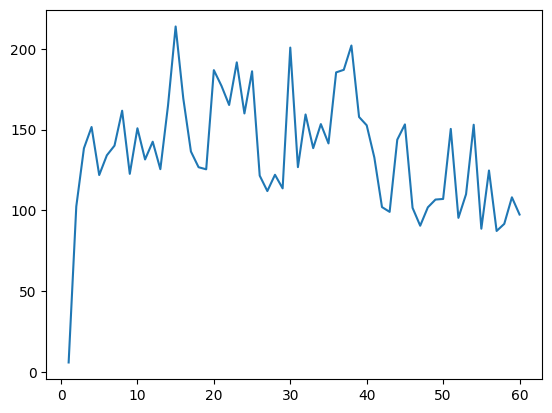

In [11]:

if __name__ == '__main__':

    print(env.observation_space)
    print(env.action_space)
    episodes = 60
    #training the model
    loss = train_dqn(episodes)
    #plotting the reward vs episode
    plt.plot([i+1 for i in range(episodes)], loss)
    plt.show()

creating a graph of the mean reward

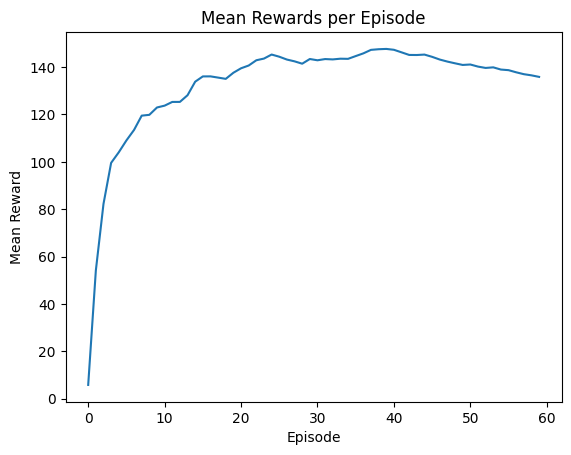

In [12]:
mean_rewards = np.zeros(episodes)
for t in range(episodes):
    mean_rewards[t] = np.mean(loss[max(0, t - 100):(t + 1)])
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Rewards per Episode')
plt.show()